In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input,Flatten,Reshape,AveragePooling2D,Dropout,LayerNormalization, ReLU,concatenate,Cropping2D, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Input,Dropout, ReLU,BatchNormalization,Concatenate,LeakyReLU,Identity

from keras.datasets import mnist
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


2024-07-26 15:38:18.564096: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
!wget  -nc https://www.dropbox.com/scl/fi/uaiyxp0t2l8hfcszfadtj/dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius&dl=1
!unzip -n -q dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius, dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.zip or dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.ZIP.

No zipfiles found.


In [4]:
image_path = '../dados/CAPTCHA-10k/treinamento'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,000001.jpg,RNINIC
1,000002.jpg,TVCFS8
2,000003.jpg,N1O1EH
3,000004.jpg,OQZSL4
4,000005.jpg,GST2YA


In [5]:
df['txt_content'].str.len().value_counts()

txt_content
6    7997
7       3
Name: count, dtype: int64

In [6]:
from PIL import Image, ImageDraw, ImageFont

font_path = '../dados/targa/Targa.ttf'

In [7]:
def generate_clean_captcha(text):
    # Fixed parameters
    size = (180, 50)  # Change size to (height, width)
    font_size = 24
    num_parts = 6

    # Create a blank white image
    image = Image.new('L', size, 255)  # 'L' mode for grayscale

    # Load the custom font
    font = ImageFont.truetype(font_path, font_size)

    # Create a drawing context
    draw = ImageDraw.Draw(image)

    # Calculate positions for each part
    part_width = size[0] / num_parts
    horizontal_positions = [int(part_width * i + part_width / 2) for i in range(num_parts)]
    horizontal_positions = horizontal_positions[:len(text)]  # Adjust to the length of the text

    # Calculate y position to center the text vertically
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_height = text_bbox[3] - text_bbox[1]
    text_y = (size[1] - text_height) // 2

    # Draw each letter at the calculated position
    for char, x in zip(text, horizontal_positions):
        char_bbox = draw.textbbox((0, 0), char, font=font)
        char_width = char_bbox[2] - char_bbox[0]
        char_x = x - char_width // 2  # Center the character horizontally within its part
        draw.text((char_x, text_y), char, font=font, fill=0)

    # Convert to numpy array if needed for further processing with OpenCV
    captcha_image = np.array(image)

    return captcha_image

In [8]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [9]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)

  Y = np.array([generate_clean_captcha(x[:6]) for x in df["txt_content"]])
  X = X.astype('float32') / 255.
  Y = Y.astype('float32') / 255.
  return X,Y

X_train, Y_train = generate_X_Y('../dados/CAPTCHA-10k/treinamento')
X_val, Y_val = generate_X_Y('../dados/CAPTCHA-10k/validacao')

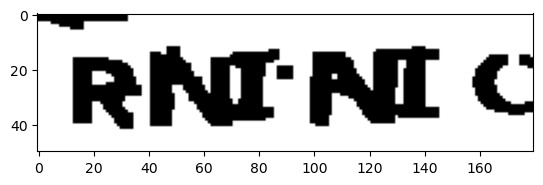

In [10]:
plt.imshow(X_train[0], cmap='gray')

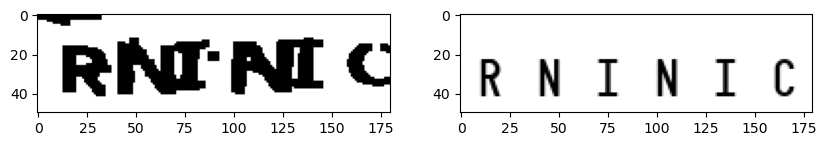

In [11]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')

# Display the corresponding Y_train[0]
plt.subplot(1, 2, 2)
plt.imshow(Y_train[0], cmap='gray')
plt.show()

In [12]:
datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train)
batch_size = 64
augmented_data_generator = datagen.flow(X_train, Y_train, batch_size=batch_size)

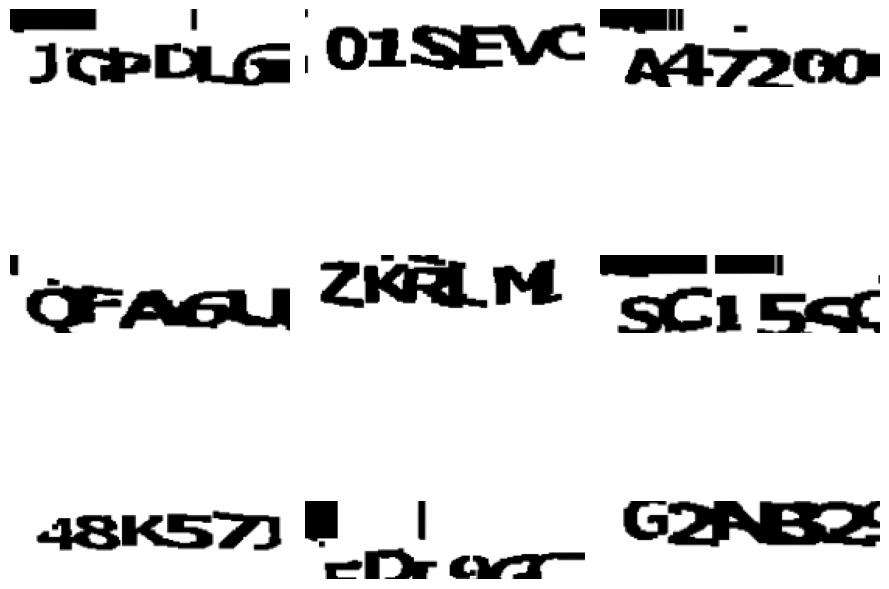

In [13]:
augmented_images, augmented_labels = next(augmented_data_generator)

# Display the first few augmented images and their corresponding labels
plt.figure(figsize=(9, 9))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].reshape(50, 180), cmap='gray')  # Assuming images are grayscale
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [15]:
#Camada Convolution-BatchNorm-ReLu
def CK(filters, kernel_size=(4, 4), strides=(2, 2), padding='same', use_batch_norm=True, downsample=True):
    '''
        filters: quantidade de filtros
        kernel_size 3x3 | strides 1x1 | padding same | sao constantes durante o codigo
        use_batch_norm ->   indica quando devemos usar BatchNormalization, em caso de negativo, a camada se torna a Identidade
        downsample ->       indica se a dimensao deve aumentar ou diminuir 
    '''

    # Esse chavemento usando  if ternario serve para selecionar as camadas com base nos atributos
    conv = Conv2D               if downsample       else Conv2DTranspose
    norm = BatchNormalization   if use_batch_norm   else Identity
    actf = LeakyReLU(0.2)       if downsample       else ReLU()
    # alpha de 0.2 na LeakyReLU foi definido no paper original

    # Com o chaveamento pronto, a camada pode ser montada sequencialmente
    def layer(x):
        x = conv(filters, kernel_size, strides=strides, padding=padding)(x)
        x = norm()(x)
        x = actf(x)
        return x
    return layer

In [16]:
def crop_and_concat(x1, x2):
    # Crop x2 to the shape of x1
    x1_shape = x1.shape
    x2_shape = x2.shape
    height_diff = x2_shape[1] - x1_shape[1]
    width_diff = x2_shape[2] - x1_shape[2]

    cropping = ((height_diff // 2, height_diff - height_diff // 2),
                (width_diff // 2, width_diff - width_diff // 2))
    x2_cropped = Cropping2D(cropping)(x2)
    return concatenate([x1, x2_cropped])

In [20]:
def generator(input_nc, output_nc, ngf, num_blocks=1, num_downsample=3):
    # Aqui, definimos o modelo gerador
    
    # Ele deve receber uma imagem (img_size,img_size,input_nc)
    inputs = Input(shape=(50, 180, input_nc))

    # --------------- START ENCODER --------------------------

    x = inputs

    # Uma convolucao eh aplicada inicialmente sem o batch_norm
    x = CK(ngf,use_batch_norm=False)(x)
    # img_shape = img_size/2,img_size/2,ngf

    # Aqui implementamos o caminho onde a dimensao da imagem vai diminuindo
    #Armazenamos as skip connections
    skips = []
    for i in range(num_downsample + num_blocks - 1):
        # Como o numero de filtros vai aumentando exponencialmente, existe um momento em que o crescimento eh cessado e a qtd se torna constante
        # Este e o momento em que i+1 >= num_downsample
        # A partir dai, o numero de filtros nao diminui
        expo = min(i+1,num_downsample)
        # Aplicamos convolucao com o numero de filtros escolhido
        x = CK(ngf*(2**(expo)))(x)
        # Guardamos a coneccao
        skips.append(x)
    
    # --------------- FIM   ENCODER --------------------------
    '''
    Aqui, a imagem esta no formato:
    img_shape = img_size/(num_downsample + num_blocks),img_size/(num_downsample + num_blocks),ngf*(2**(expo))
    
    '''
    # --------------- START DECODER --------------------------
    # As conexoes sao processadas de tras pra frente, ja que a ultima skip gerada vai se ligar com a primeira camada do decoder
    skips = list(reversed(skips))


    # Para as skips que sobraram, devemos conecta-las a camadas sem dropout
    for skip in skips:
        x = crop_and_concat(skip,x)
        # x = Concatenate()([x, skip])
        x = CK(ngf * (2 ** i),downsample=False)(x)
    
    #    img_shape = img_size/(2),img_size/(2),ngf*(2**(expo))
    # --------------- FIM   DECODER --------------------------

    # Por fim, uma ultima convolucao com TanH para gerar o resultado final
    # Numero de canais = output_nc  = 3 = RGB
    x = Conv2DTranspose(ngf, (4, 4),strides=(2,2), activation='relu',padding="same")(x)
    x = Conv2D(ngf, (3, 1),strides=(1,1), activation='relu')(x)
    output = Conv2D(output_nc, (1, 1),strides=(1,1), activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=output)

autoencoder = generator(1, 1, 16, num_blocks=2, num_downsample=3)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[rmse,psnr])
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 180, 1)]         0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 25, 90, 16)           272       ['input_2[0][0]']             
                                                                                                  
 identity_1 (Identity)       (None, 25, 90, 16)           0         ['conv2d_7[0][0]']            
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)   (None, 25, 90, 16)           0         ['identity_1[0][0]']          
                                                                                            

In [21]:
checkpoint = ModelCheckpoint(
    'model_BCE_aug_best_unet.tf',
    monitor='val_rmse',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [22]:
history = autoencoder.fit(augmented_data_generator,
                steps_per_epoch=len(X_train) // batch_size,
                epochs=300,
                batch_size=batch_size,
                shuffle=True,
                callbacks=[checkpoint],
                validation_data=(X_val, Y_val))

Epoch 1/300
125/125 [==============================] - ETA: 0s - loss: 0.1130 - rmse: 0.1709 - psnr: 15.4823
Epoch 1: val_rmse improved from inf to 0.16637, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 13s 68ms/step - loss: 0.1130 - rmse: 0.1709 - psnr: 15.4823 - val_loss: 0.1020 - val_rmse: 0.1664 - val_psnr: 15.5788
Epoch 2/300
125/125 [==============================] - ETA: 0s - loss: 0.0864 - rmse: 0.1491 - psnr: 16.5344
Epoch 2: val_rmse improved from 0.16637 to 0.15065, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 8s 60ms/step - loss: 0.0864 - rmse: 0.1491 - psnr: 16.5344 - val_loss: 0.0921 - val_rmse: 0.1507 - val_psnr: 16.4408
Epoch 3/300
125/125 [==============================] - ETA: 0s - loss: 0.0755 - rmse: 0.1338 - psnr: 17.4787
Epoch 3: val_rmse improved from 0.15065 to 0.13751, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 8s 65ms/step - loss: 0.0755 - rmse: 0.1338 - psnr: 17.4787 - val_loss: 0.0838 - val_rmse: 0.1375 - val_psnr: 17.2342
Epoch 4/300
124/125 [============================>.] - ETA: 0s - loss: 0.0647 - rmse: 0.1177 - psnr: 18.5937
Epoch 4: val_rmse improved from 0.13751 to 0.11807, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 7s 57ms/step - loss: 0.0647 - rmse: 0.1176 - psnr: 18.5973 - val_loss: 0.0662 - val_rmse: 0.1181 - val_psnr: 18.5602
Epoch 5/300
125/125 [==============================] - ETA: 0s - loss: 0.0574 - rmse: 0.1061 - psnr: 19.4962
Epoch 5: val_rmse improved from 0.11807 to 0.09893, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 7s 60ms/step - loss: 0.0574 - rmse: 0.1061 - psnr: 19.4962 - val_loss: 0.0539 - val_rmse: 0.0989 - val_psnr: 20.0970
Epoch 6/300
125/125 [==============================] - ETA: 0s - loss: 0.0524 - rmse: 0.0974 - psnr: 20.2391
Epoch 6: val_rmse improved from 0.09893 to 0.09179, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 7s 58ms/step - loss: 0.0524 - rmse: 0.0974 - psnr: 20.2391 - val_loss: 0.0495 - val_rmse: 0.0918 - val_psnr: 20.7484
Epoch 7/300
125/125 [==============================] - ETA: 0s - loss: 0.0491 - rmse: 0.0913 - psnr: 20.7990
Epoch 7: val_rmse improved from 0.09179 to 0.08452, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 8s 62ms/step - loss: 0.0491 - rmse: 0.0913 - psnr: 20.7990 - val_loss: 0.0456 - val_rmse: 0.0845 - val_psnr: 21.4683
Epoch 8/300
125/125 [==============================] - ETA: 0s - loss: 0.0464 - rmse: 0.0863 - psnr: 21.2943
Epoch 8: val_rmse improved from 0.08452 to 0.07644, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 8s 66ms/step - loss: 0.0464 - rmse: 0.0863 - psnr: 21.2943 - val_loss: 0.0418 - val_rmse: 0.0764 - val_psnr: 22.3448
Epoch 9/300
125/125 [==============================] - ETA: 0s - loss: 0.0446 - rmse: 0.0826 - psnr: 21.6675
Epoch 9: val_rmse improved from 0.07644 to 0.07208, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 7s 58ms/step - loss: 0.0446 - rmse: 0.0826 - psnr: 21.6675 - val_loss: 0.0397 - val_rmse: 0.0721 - val_psnr: 22.8600
Epoch 10/300
125/125 [==============================] - ETA: 0s - loss: 0.0433 - rmse: 0.0800 - psnr: 21.9525
Epoch 10: val_rmse improved from 0.07208 to 0.06735, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 8s 60ms/step - loss: 0.0433 - rmse: 0.0800 - psnr: 21.9525 - val_loss: 0.0376 - val_rmse: 0.0673 - val_psnr: 23.4475
Epoch 11/300
124/125 [============================>.] - ETA: 0s - loss: 0.0419 - rmse: 0.0773 - psnr: 22.2526
Epoch 11: val_rmse did not improve from 0.06735
125/125 [==============================] - 5s 38ms/step - loss: 0.0419 - rmse: 0.0773 - psnr: 22.2541 - val_loss: 0.0391 - val_rmse: 0.0707 - val_psnr: 23.0239
Epoch 12/300
124/125 [============================>.] - ETA: 0s - loss: 0.0415 - rmse: 0.0763 - psnr: 22.3682
Epoch 12: val_rmse improved from 0.06735 to 0.06440, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 8s 61ms/step - loss: 0.0415 - rmse: 0.0763 - psnr: 22.3656 - val_loss: 0.0364 - val_rmse: 0.0644 - val_psnr: 23.8440
Epoch 13/300
124/125 [============================>.] - ETA: 0s - loss: 0.0405 - rmse: 0.0742 - psnr: 22.6045
Epoch 13: val_rmse did not improve from 0.06440
125/125 [==============================] - 6s 46ms/step - loss: 0.0405 - rmse: 0.0742 - psnr: 22.6061 - val_loss: 0.0377 - val_rmse: 0.0674 - val_psnr: 23.4444
Epoch 14/300
125/125 [==============================] - ETA: 0s - loss: 0.0399 - rmse: 0.0730 - psnr: 22.7493
Epoch 14: val_rmse did not improve from 0.06440
125/125 [==============================] - 5s 36ms/step - loss: 0.0399 - rmse: 0.0730 - psnr: 22.7493 - val_loss: 0.0367 - val_rmse: 0.0653 - val_psnr: 23.7157
Epoch 15/300
125/125 [==============================] - ETA: 0s - loss: 0.0394 - rmse: 0.0718 - psnr: 22.9002
Epoch 15: val_rmse improved from 0.06440 to 0.06300, saving model to model_BCE_aug_best_unet.t

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 7s 56ms/step - loss: 0.0394 - rmse: 0.0718 - psnr: 22.9002 - val_loss: 0.0359 - val_rmse: 0.0630 - val_psnr: 24.0316
Epoch 16/300
125/125 [==============================] - ETA: 0s - loss: 0.0390 - rmse: 0.0711 - psnr: 22.9882
Epoch 16: val_rmse improved from 0.06300 to 0.06078, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 7s 58ms/step - loss: 0.0390 - rmse: 0.0711 - psnr: 22.9882 - val_loss: 0.0350 - val_rmse: 0.0608 - val_psnr: 24.3528
Epoch 17/300
124/125 [============================>.] - ETA: 0s - loss: 0.0385 - rmse: 0.0699 - psnr: 23.1332
Epoch 17: val_rmse improved from 0.06078 to 0.05924, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 7s 59ms/step - loss: 0.0385 - rmse: 0.0699 - psnr: 23.1358 - val_loss: 0.0343 - val_rmse: 0.0592 - val_psnr: 24.5714
Epoch 18/300
124/125 [============================>.] - ETA: 0s - loss: 0.0383 - rmse: 0.0696 - psnr: 23.1770
Epoch 18: val_rmse did not improve from 0.05924
125/125 [==============================] - 5s 39ms/step - loss: 0.0383 - rmse: 0.0695 - psnr: 23.1821 - val_loss: 0.0352 - val_rmse: 0.0616 - val_psnr: 24.2305
Epoch 19/300
125/125 [==============================] - ETA: 0s - loss: 0.0377 - rmse: 0.0682 - psnr: 23.3437
Epoch 19: val_rmse improved from 0.05924 to 0.05917, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 7s 58ms/step - loss: 0.0377 - rmse: 0.0682 - psnr: 23.3437 - val_loss: 0.0343 - val_rmse: 0.0592 - val_psnr: 24.5846
Epoch 20/300
125/125 [==============================] - ETA: 0s - loss: 0.0377 - rmse: 0.0683 - psnr: 23.3263
Epoch 20: val_rmse did not improve from 0.05917
125/125 [==============================] - 5s 38ms/step - loss: 0.0377 - rmse: 0.0683 - psnr: 23.3263 - val_loss: 0.0353 - val_rmse: 0.0619 - val_psnr: 24.1807
Epoch 21/300
125/125 [==============================] - ETA: 0s - loss: 0.0374 - rmse: 0.0674 - psnr: 23.4496
Epoch 21: val_rmse improved from 0.05917 to 0.05748, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 7s 59ms/step - loss: 0.0374 - rmse: 0.0674 - psnr: 23.4496 - val_loss: 0.0335 - val_rmse: 0.0575 - val_psnr: 24.8347
Epoch 22/300
125/125 [==============================] - ETA: 0s - loss: 0.0371 - rmse: 0.0670 - psnr: 23.5085
Epoch 22: val_rmse improved from 0.05748 to 0.05673, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 7s 57ms/step - loss: 0.0371 - rmse: 0.0670 - psnr: 23.5085 - val_loss: 0.0332 - val_rmse: 0.0567 - val_psnr: 24.9491
Epoch 23/300
125/125 [==============================] - ETA: 0s - loss: 0.0369 - rmse: 0.0664 - psnr: 23.5815
Epoch 23: val_rmse did not improve from 0.05673
125/125 [==============================] - 5s 38ms/step - loss: 0.0369 - rmse: 0.0664 - psnr: 23.5815 - val_loss: 0.0335 - val_rmse: 0.0573 - val_psnr: 24.8549
Epoch 24/300
124/125 [============================>.] - ETA: 0s - loss: 0.0365 - rmse: 0.0654 - psnr: 23.7149
Epoch 24: val_rmse improved from 0.05673 to 0.05651, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 8s 62ms/step - loss: 0.0365 - rmse: 0.0655 - psnr: 23.7115 - val_loss: 0.0332 - val_rmse: 0.0565 - val_psnr: 24.9798
Epoch 25/300
125/125 [==============================] - ETA: 0s - loss: 0.0364 - rmse: 0.0652 - psnr: 23.7456
Epoch 25: val_rmse improved from 0.05651 to 0.05517, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 8s 60ms/step - loss: 0.0364 - rmse: 0.0652 - psnr: 23.7456 - val_loss: 0.0327 - val_rmse: 0.0552 - val_psnr: 25.1901
Epoch 26/300
124/125 [============================>.] - ETA: 0s - loss: 0.0361 - rmse: 0.0646 - psnr: 23.8226
Epoch 26: val_rmse did not improve from 0.05517
125/125 [==============================] - 5s 39ms/step - loss: 0.0361 - rmse: 0.0647 - psnr: 23.8197 - val_loss: 0.0341 - val_rmse: 0.0591 - val_psnr: 24.5926
Epoch 27/300
124/125 [============================>.] - ETA: 0s - loss: 0.0361 - rmse: 0.0646 - psnr: 23.8322
Epoch 27: val_rmse did not improve from 0.05517
125/125 [==============================] - 5s 38ms/step - loss: 0.0361 - rmse: 0.0646 - psnr: 23.8286 - val_loss: 0.0334 - val_rmse: 0.0569 - val_psnr: 24.9199
Epoch 28/300
125/125 [==============================] - ETA: 0s - loss: 0.0357 - rmse: 0.0636 - psnr: 23.9589
Epoch 28: val_rmse improved from 0.05517 to 0.05405, saving model to model_BCE_aug_best_unet.t

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 7s 58ms/step - loss: 0.0357 - rmse: 0.0636 - psnr: 23.9589 - val_loss: 0.0323 - val_rmse: 0.0541 - val_psnr: 25.3749
Epoch 29/300
125/125 [==============================] - ETA: 0s - loss: 0.0356 - rmse: 0.0634 - psnr: 23.9940
Epoch 29: val_rmse improved from 0.05405 to 0.05361, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 8s 61ms/step - loss: 0.0356 - rmse: 0.0634 - psnr: 23.9940 - val_loss: 0.0322 - val_rmse: 0.0536 - val_psnr: 25.4456
Epoch 30/300
125/125 [==============================] - ETA: 0s - loss: 0.0355 - rmse: 0.0631 - psnr: 24.0343
Epoch 30: val_rmse did not improve from 0.05361
125/125 [==============================] - 5s 38ms/step - loss: 0.0355 - rmse: 0.0631 - psnr: 24.0343 - val_loss: 0.0337 - val_rmse: 0.0573 - val_psnr: 24.8616
Epoch 31/300
124/125 [============================>.] - ETA: 0s - loss: 0.0354 - rmse: 0.0630 - psnr: 24.0590
Epoch 31: val_rmse did not improve from 0.05361
125/125 [==============================] - 5s 38ms/step - loss: 0.0354 - rmse: 0.0629 - psnr: 24.0659 - val_loss: 0.0350 - val_rmse: 0.0609 - val_psnr: 24.3276
Epoch 32/300
124/125 [============================>.] - ETA: 0s - loss: 0.0353 - rmse: 0.0626 - psnr: 24.1048
Epoch 32: val_rmse improved from 0.05361 to 0.05256, saving model to model_BCE_aug_best_unet.t

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 8s 60ms/step - loss: 0.0353 - rmse: 0.0625 - psnr: 24.1174 - val_loss: 0.0319 - val_rmse: 0.0526 - val_psnr: 25.6229
Epoch 33/300
125/125 [==============================] - ETA: 0s - loss: 0.0350 - rmse: 0.0620 - psnr: 24.1925
Epoch 33: val_rmse did not improve from 0.05256
125/125 [==============================] - 5s 38ms/step - loss: 0.0350 - rmse: 0.0620 - psnr: 24.1925 - val_loss: 0.0321 - val_rmse: 0.0533 - val_psnr: 25.5088
Epoch 34/300
125/125 [==============================] - ETA: 0s - loss: 0.0352 - rmse: 0.0624 - psnr: 24.1296
Epoch 34: val_rmse did not improve from 0.05256
125/125 [==============================] - 5s 38ms/step - loss: 0.0352 - rmse: 0.0624 - psnr: 24.1296 - val_loss: 0.0338 - val_rmse: 0.0580 - val_psnr: 24.7599
Epoch 35/300
124/125 [============================>.] - ETA: 0s - loss: 0.0347 - rmse: 0.0613 - psnr: 24.2973
Epoch 35: val_rmse did not improve from 0.05256
125/125 [==============================] - 5s 

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 7s 58ms/step - loss: 0.0343 - rmse: 0.0605 - psnr: 24.3977 - val_loss: 0.0318 - val_rmse: 0.0524 - val_psnr: 25.6491
Epoch 41/300
125/125 [==============================] - ETA: 0s - loss: 0.0343 - rmse: 0.0607 - psnr: 24.3703
Epoch 41: val_rmse improved from 0.05237 to 0.05215, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


125/125 [==============================] - 7s 60ms/step - loss: 0.0343 - rmse: 0.0607 - psnr: 24.3703 - val_loss: 0.0318 - val_rmse: 0.0522 - val_psnr: 25.6948
Epoch 42/300
125/125 [==============================] - ETA: 0s - loss: 0.0340 - rmse: 0.0598 - psnr: 24.5002
Epoch 42: val_rmse did not improve from 0.05215
125/125 [==============================] - 5s 37ms/step - loss: 0.0340 - rmse: 0.0598 - psnr: 24.5002 - val_loss: 0.0325 - val_rmse: 0.0539 - val_psnr: 25.4043
Epoch 43/300
124/125 [============================>.] - ETA: 0s - loss: 0.0339 - rmse: 0.0595 - psnr: 24.5445
Epoch 43: val_rmse did not improve from 0.05215
125/125 [==============================] - 5s 37ms/step - loss: 0.0339 - rmse: 0.0596 - psnr: 24.5360 - val_loss: 0.0328 - val_rmse: 0.0549 - val_psnr: 25.2398
Epoch 44/300
125/125 [==============================] - ETA: 0s - loss: 0.0339 - rmse: 0.0596 - psnr: 24.5343
Epoch 44: val_rmse did not improve from 0.05215
125/125 [==============================] - 5s 

KeyboardInterrupt: 

In [23]:
Y_train_pred = autoencoder.predict(X_train)
Y_val_pred = autoencoder.predict(X_val)

32/32 [==============================] - 1s 14ms/step


In [24]:
def display_images(images, Y, Y_pred, num_images=10):
    indices = np.random.choice(len(images), num_images, replace=False)
    plt.figure(figsize=(20, 6))
    for i, idx in enumerate(indices):
        # Original images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(images[idx].reshape(50,180), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Ground truth labels (Y)
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(Y[idx].reshape(50, 180), cmap="gray")
        plt.title("Y")
        plt.axis("off")

        # Reconstructed images (Y_pred)
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(Y_pred[idx].reshape(50, 180), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

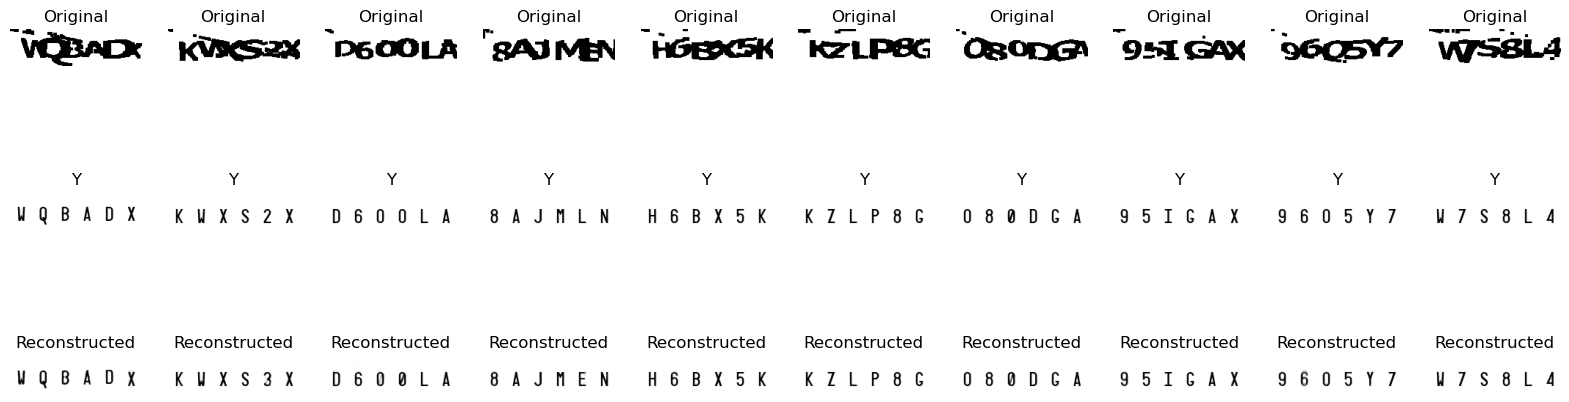

In [25]:
display_images(X_train, Y_train, Y_train_pred, num_images=10)

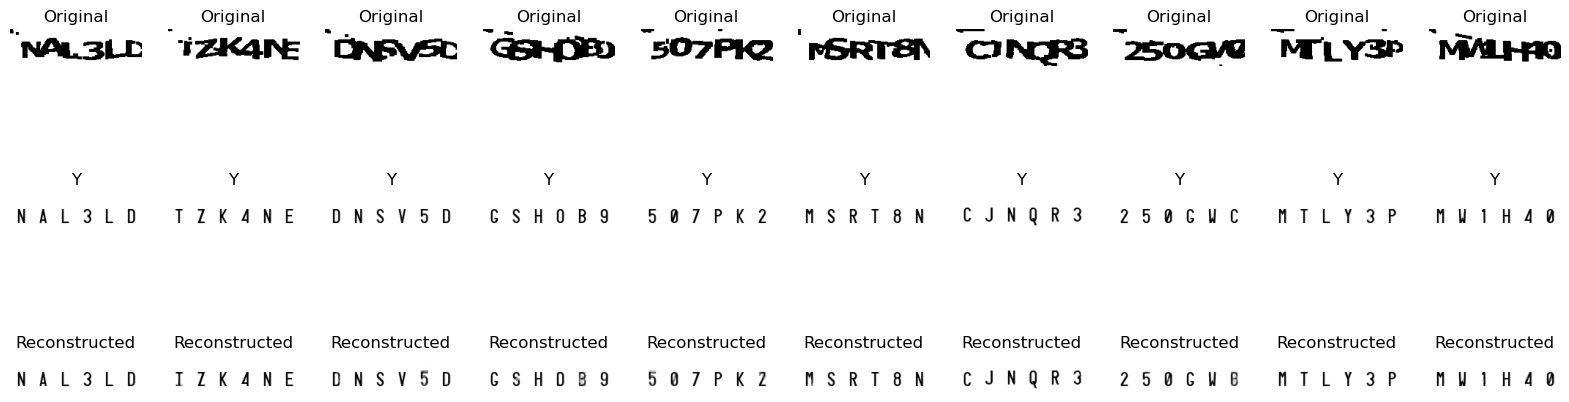

In [26]:
display_images(X_val, Y_val, Y_val_pred, num_images=10)